In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print(f'The GPU device name is {torch.cuda.get_device_name(0)}.')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
The GPU device name is Tesla T4.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import torch
from torch import nn, optim
import matplotlib.pyplot as plt


In [ ]:
col_names = ['h', 't', 'r']
train_df = pd.read_csv("/content/sample_data/train.txt", header=None, delim_whitespace=True, names=col_names)
val_df = pd.read_csv("/content/sample_data/valid.txt", header=None, delim_whitespace=True, names=col_names)
test_df = pd.read_csv("/content/sample_data/test.txt", header=None, delim_whitespace=True, names=col_names)
entity2id = pd.read_csv("/content/sample_data/entity2id.txt", header=None, delim_whitespace=True)
relation2id = pd.read_csv("/content/sample_data/relation2id.txt", header=None, delim_whitespace=True)

rel_len = len(relation2id)
entity_len = len(entity2id)

all_entities = entity2id[0].values

In [ ]:
train_df = pd.read_csv("/content/sample_data/train.txt", header=None, delim_whitespace=True, names=col_names)
num_train_examples = train_df.shape[0]
print("Nombre d'exemples d'entraînement : ", num_train_examples)

Nombre d'exemples d'entraînement :  483142


In [ ]:
val_df = pd.read_csv("/content/sample_data/valid.txt", header=None, delim_whitespace=True, names=col_names)
num_val_examples = val_df.shape[0]
print("Nombre d'exemples d'entraînement : ", num_val_examples)

Nombre d'exemples d'entraînement :  50000


In [ ]:

test_df = pd.read_csv("/content/sample_data/test.txt", header=None, delim_whitespace=True, names=col_names)
num_test_examples = val_df.shape[0]
print("Nombre d'exemples d'entraînement : ", num_test_examples)

Nombre d'exemples d'entraînement :  50000


In [ ]:
entity2id_dict = dict((v,k) for k,v in entity2id.to_dict()[0].items())
relation2id_dict = dict((v,k) for k,v in relation2id.to_dict()[0].items())


In [ ]:
def map_triplets(df, entity2id, rel2id):
    print("mapping started")
    df['h'] = df.apply(lambda L: entity2id_dict[L[0]], axis=1)
    df['t'] = df.apply(lambda L: entity2id_dict[L[1]], axis=1)
    df['r'] = df.apply(lambda L: relation2id_dict[L[2]], axis=1)
    print("mapping end")


In [ ]:
map_triplets(train_df, entity2id_dict, relation2id_dict)
map_triplets(val_df, entity2id_dict, relation2id_dict)
map_triplets(test_df, entity2id_dict, relation2id_dict)

mapping started
mapping end
mapping started
mapping end
mapping started
mapping end


In [ ]:
class TransE(nn.Module):
    def __init__(self, entity_len, rel_len, embedding_dim, margin=0.5):
        super(TransE, self).__init__()

        self.entity_embeddings = nn.Embedding(entity_len, embedding_dim,).cuda()
        self.rel_embeddings = nn.Embedding(rel_len, embedding_dim).cuda()

        embeddings_init_bound = 6 / np.sqrt(embedding_dim)
        nn.init.uniform_(
            self.entity_embeddings.weight.data,
            a=-embeddings_init_bound,
            b=+embeddings_init_bound,
        )

        nn.init.uniform_(
            self.rel_embeddings.weight.data,
            a=-embeddings_init_bound,
            b=+embeddings_init_bound,
        )

        self.criterion = nn.MarginRankingLoss(
            margin=margin
        )

        norms = torch.norm(self.rel_embeddings.weight, p=2, dim=1).data
        self.rel_embeddings.weight.data = self.rel_embeddings.weight.data.div(
            norms.view(rel_len, 1).expand_as(self.rel_embeddings.weight))


    def generate_negative_triplets(self, pos_batch, all_entities):
        current_batch_size = len(pos_batch)
        batch_subjs = pos_batch[:, 0:1]
        batch_relations = pos_batch[:, 2:3]
        batch_objs = pos_batch[:, 1:2]

        num_subj_corrupt = len(pos_batch) // 2
        num_obj_corrupt = len(pos_batch) - num_subj_corrupt
        pos_batch = torch.tensor(pos_batch, dtype=torch.long)

        corrupted_subj_indices = np.random.choice(np.arange(0, all_entities.shape[0]), size=num_subj_corrupt)
        corrupted_subjects = np.reshape(all_entities[corrupted_subj_indices], newshape=(-1, 1))
        corrupted_converted_subjects = np.apply_along_axis(self.entities_to_ids,1,corrupted_subjects).reshape(num_subj_corrupt,1)
        subject_based_corrupted_triples = np.concatenate(
            [corrupted_converted_subjects, (batch_objs[:num_subj_corrupt]).cpu(), (batch_relations[:num_subj_corrupt]).cpu()], axis=1)

        corrupted_obj_indices = np.random.choice(np.arange(0, all_entities.shape[0]), size=num_obj_corrupt)
        corrupted_objects = np.reshape(all_entities[corrupted_obj_indices], newshape=(-1, 1))
        corrupted_converted_objects = np.apply_along_axis(self.entities_to_ids,1,corrupted_objects).reshape(num_obj_corrupt,1)
        object_based_corrupted_triples = np.concatenate(
            [(batch_subjs[num_subj_corrupt:]).cpu(), corrupted_converted_objects, (batch_relations[num_subj_corrupt:]).cpu()], axis=1)
        batch_subjs.cuda()
        batch_relations.cuda()
        batch_objs.cuda()
        neg_batch = np.concatenate([subject_based_corrupted_triples, object_based_corrupted_triples], axis=0)
        neg_batch = torch.tensor(neg_batch, dtype=torch.long).cuda()
        return neg_batch



    def entities_to_ids(self, entities):
        return entity2id_dict[entities[0]]

    def forward(self, pos_batch, neg_batch):
        pos_score = self.score_triplets(pos_batch)
        neg_score = self.score_triplets(neg_batch)

        loss = self.compute_loss(pos_score, neg_score)
        return loss #Finalement, la méthode "forward" retourne la perte (loss), qui sera utilisée pour mettre à jour les poids


    def train(self, triplets, all_entities, batchsize=32, epochs=20):
        triplets_len = triplets.shape[0]
        optimiser = optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        loss_hist = []
        for epoch in range(epochs):
            print("Epoch: {} is started.".format(epoch))
            for i in range(0,triplets_len,batchsize):
                #raises error if last batch contains only one element!!
                pos_batch = triplets[i:i+batchsize]
                neg_batch = self.generate_negative_triplets(pos_batch, all_entities)
                optimiser.zero_grad()

                loss = self.forward(pos_batch, neg_batch)
                loss_hist.append(loss)
               # print("Calculated loss for iteration {}: {}".format(i,loss))
               # if (epoch + 1) % valid_freq == 0:
                 # mrr_score, mr_score, hits_at_10 = eval(model, data.valid_edge_index.to(device),
                              #               data.valid_edge_type.to(device),
                               #              data.num_entities, device)
                 # print(f'Validation score equals {mrr_score}, {mr_score}, {hits_at_10}')
                 # if mrr_score > best_valid_score:
                  # valid_scores = (mrr_score, mr_score, hits_at_10)
                   #test_mmr_score, test_mr_score, test_hits_at_10 = \
                                       # eval(model, data.valid_edge_index.to(device),
                                            # data.valid_edge_type.to(device),
                                           #  data.num_entities, device)
                  # test_scores = (test_mmr_score, test_mr_score, test_hits_at_10)
    # break
    #print(f'Test scores from best model (mmr, mr, h@10): {test_scores}')
                loss.backward()
                optimiser.step()

        return loss_hist
    def compute_loss(self, pos_scores, neg_scores):
        y = np.repeat([1], repeats=pos_scores.shape[0])
        y = torch.tensor(y, dtype=torch.float)

        positive_scores = torch.tensor(pos_scores, dtype=torch.float)
        negative_scores = torch.tensor(neg_scores, dtype=torch.float)

        loss = self.criterion(pos_scores.cpu(), neg_scores.cpu(), y)

        return loss

    def split_triplets(self, triplets):
        h = triplets[:, 0:1]
        t = triplets[:, 1:2]
        r = triplets[:, 2:3]
        return h, t, r

    #it is very important how to vectorize code. Before, i was using numpy.apply_along_axis function to fetch the embeddings
    #since it is using numpy, apply function was fetching the embeddings one by one with using vectorization.
    #however, this was creating a ndarray of tensors which i do not want.
    #then, i realize it is possible to give a tensor(which has indices of relevant embeddings) to embeddings.weight.data
    #to fetch the relevant embeddings. Since I am fetching directly from nn.embedding (is of type tensor) now resulting
    #data is also tensor in the shape I want.

    def get_embedding_of_triplets(self, triplets):
        heads, tails, relations = self.split_triplets(triplets)
        #print("SHAPE ",self.entity_embeddings.weight[heads].reshape(heads.shape[0],-1).shape)
        return self.entity_embeddings.weight[heads].reshape(heads.shape[0],-1), self.entity_embeddings.weight[tails].reshape(heads.shape[0],-1), self.entity_embeddings.weight[relations].reshape(heads.shape[0],-1)

    def score_triplets(self, triplets):
        print(self.entity_embeddings.weight.data)
        norms = torch.norm(self.entity_embeddings.weight, dim=1).data
        self.entity_embeddings.weight.data = self.entity_embeddings.weight.data.div(norms.view(entity_len, 1).expand_as(self.entity_embeddings.weight))
        print(self.entity_embeddings.weight.data)
        heads, tails, rels = self.get_embedding_of_triplets(triplets)
        sum_res = heads + rels - tails
        distances = torch.norm(sum_res, p=1, dim=1)
        distances_view = distances.view(size=(-1,))

        return distances_view





In [ ]:
embedding_dim = 5
entity_len = 14951
rel_len = 1345
bitch_size = 128
model = TransE(entity_len, rel_len,  embedding_dim, margin=1)
pos_triplets = torch.from_numpy(train_df.values).cuda()
len_pos_triplets = pos_triplets.shape[0]

loss_hist = model.train(pos_triplets, all_entities,len_pos_triplets,epochs=1000)


for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)
    else:
        print(param.name)

Epoch: 0 is started.


<ipython-input-16-90c15fd0f7fb>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_batch = torch.tensor(pos_batch, dtype=torch.long)


tensor([[ 0.0083, -2.6570,  0.8729,  0.5889, -2.6381],
        [-2.6738, -0.4711, -0.6320, -2.1117,  0.5517],
        [-0.4556, -1.5269, -2.3245, -0.3027, -1.9482],
        ...,
        [-0.7696, -0.8352, -1.8353, -0.8096, -0.2334],
        [ 0.8507, -2.5327,  1.7946,  1.2209, -1.5155],
        [ 0.4670,  0.1745,  1.1691, -1.5573,  0.4006]], device='cuda:0')
tensor([[ 0.0021, -0.6831,  0.2244,  0.1514, -0.6783],
        [-0.7552, -0.1331, -0.1785, -0.5965,  0.1558],
        [-0.1325, -0.4439, -0.6759, -0.0880, -0.5664],
        ...,
        [-0.3322, -0.3605, -0.7921, -0.3494, -0.1008],
        [ 0.2262, -0.6734,  0.4772,  0.3246, -0.4029],
        [ 0.2278,  0.0851,  0.5704, -0.7598,  0.1954]], device='cuda:0')
tensor([[ 0.0021, -0.6831,  0.2244,  0.1514, -0.6783],
        [-0.7552, -0.1331, -0.1785, -0.5965,  0.1558],
        [-0.1325, -0.4439, -0.6759, -0.0880, -0.5664],
        ...,
        [-0.3322, -0.3605, -0.7921, -0.3494, -0.1008],
        [ 0.2262, -0.6734,  0.4772,  0.3246, 

<ipython-input-16-90c15fd0f7fb>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_scores = torch.tensor(pos_scores, dtype=torch.float)
<ipython-input-16-90c15fd0f7fb>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_scores = torch.tensor(neg_scores, dtype=torch.float)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
        [ 2.2733e-01,  8.4552e-02,  5.7057e-01, -7.5986e-01,  1.9555e-01]],
       device='cuda:0')
Epoch: 849 is started.
tensor([[ 6.3203e-04, -6.8268e-01,  2.2545e-01,  1.5028e-01, -6.7862e-01],
        [-7.4871e-01, -1.3720e-01, -2.0575e-01, -5.9747e-01,  1.4587e-01],
        [-1.3479e-01, -4.4609e-01, -6.7550e-01, -9.0253e-02, -5.6427e-01],
        ...,
        [-3.3185e-01, -3.6074e-01, -7.9263e-01, -3.4815e-01, -1.0130e-01],
        [ 2.2614e-01, -6.7323e-01,  4.7777e-01,  3.2495e-01, -4.0219e-01],
        [ 2.2733e-01,  8.4551e-02,  5.7057e-01, -7.5985e-01,  1.9555e-01]],
       device='cuda:0')
tensor([[ 6.3203e-04, -6.8269e-01,  2.2545e-01,  1.5028e-01, -6.7862e-01],
        [-7.4872e-01, -1.3721e-01, -2.0576e-01, -5.9748e-01,  1.4587e-01],
        [-1.3479e-01, -4.4609e-01, -6.7550e-01, -9.0253e-02, -5.6427e-01],
        ...,
        [-3.3185e-01, -3.6074e-01, -7.9264e-01, -3.4815e-01, -1.0130e-01]

In [ ]:
def mr(predictions, gt):
  indices = predictions.argsort()
  return ((indices == gt).nonzero()[:, 1].float().add(1.0)).sum().item()

def hit_at_k(predictions, gt, device, k=10):
  """Hit @ k score adopted from
  https://github.com/mklimasz/TransE-PyTorch/blob/master/metric.py
  """
  zero_tensor = torch.tensor([0], device=device)
  one_tensor = torch.tensor([1], device=device)
  _, indices = predictions.topk(k=k, largest=False)
  return torch.where(indices == gt, one_tensor, zero_tensor).sum().item()

In [ ]:
def eval(model, edge_index, edge_type, num_entities, device, eval_batch_size=64):
  model.eval()
  num_triples = edge_type.size()[0]
  mr_score = 0
  hits_at_10 = 0
  num_predictions = 0

  for batch_idx in range(math.ceil(num_triples / eval_batch_size)):
    batch_start = batch_idx * eval_batch_size
    batch_end = (batch_idx + 1) * eval_batch_size
    batch_edge_index = edge_index[:,batch_start:batch_end]
    batch_edge_type = edge_type[batch_start:batch_end]
    batch_size = batch_edge_type.size()[0] # can be different on last batch

    all_entities = torch.arange(end=num_entities,
                                device=device).unsqueeze(0).repeat(batch_size, 1)
    head_repeated = batch_edge_index[0,:].reshape(-1, 1).repeat(1, num_entities)
    relation_repeated = batch_edge_type.reshape(-1, 1).repeat(1, num_entities)

    head_squeezed = head_repeated.reshape(-1)
    relation_squeezed = relation_repeated.reshape(-1)
    all_entities_squeezed = all_entities.reshape(-1)

    entity_index_replaced_tail = torch.stack((head_squeezed,all_entities_squeezed))
    predictions = model.predict(entity_index_replaced_tail, relation_squeezed)
    predictions = predictions.reshape(batch_size, -1)
    gt = batch_edge_index[1,:].reshape(-1, 1)


    mr_score += mr(predictions, gt)
    hits_at_10 += hit_at_k(predictions, gt, device=device, k=10)
    num_predictions += predictions.size()[0]


  mr_score = mr_score / num_predictions
  hits_at_10 = hits_at_10 / num_predictions
  return  mr_score, hits_at_10

RuntimeError: ignored

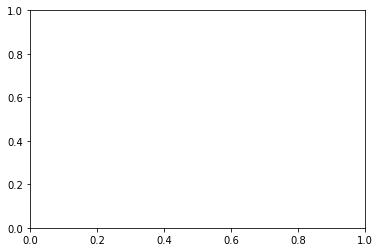

In [ ]:
plt.plot(loss_hist)
plt.ylabel('some numbers')
plt.show()

In [ ]:
subj = entity2id_dict['/m/027rn']
rel = relation2id_dict['/location/country/form_of_government']
obj = entity2id_dict['/m/06cx9']
print("subj index: ", subj)
print("rel index: ", rel)
print("obj index: ", obj)

subj_embed = model.entity_embeddings.weight[subj]
rel_embed = model.rel_embeddings.weight[rel]
obj_embed = model.entity_embeddings.weight[obj]

print("subj embed: ", subj_embed)
print("rel embed: ", rel_embed)
print("obj embed: ", obj_embed)
print("sum embed: ", subj_embed+rel_embed - obj_embed)

subj index:  9447
rel index:  352
obj index:  5030
subj embed:  tensor([-0.2390,  0.3026,  0.5800, -0.6567,  0.2892], device='cuda:0',
       grad_fn=<SelectBackward0>)
rel embed:  tensor([-0.1532,  0.6322, -0.6300, -0.2014, -0.3733], device='cuda:0',
       grad_fn=<SelectBackward0>)
obj embed:  tensor([-0.0521,  0.5232,  0.0011,  0.4349,  0.7310], device='cuda:0',
       grad_fn=<SelectBackward0>)
sum embed:  tensor([-0.3402,  0.4116, -0.0512, -1.2930, -0.8152], device='cuda:0',
       grad_fn=<SubBackward0>)


In [ ]:
import sys
sys.path.append('../..')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [ ]:
pip install ampligraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.3/178.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB

In [ ]:
import ampligraph
# Benchmark datasets are under ampligraph.datasets module
from ampligraph.datasets import load_fb15k_237
# load fb15k-237 dataset
dataset = load_fb15k_237()

In [ ]:
# Import the KGE model
from ampligraph.latent_features import ScoringBasedEmbeddingModel

# you can continue training from where you left after restoring the model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./transe_train_logs')

# create the model with transe scoring function
model = ScoringBasedEmbeddingModel(eta=5,
                                   k=300,
                                   scoring_type='TransE')

# you can either use optimizers/regularizers/loss/initializers with default values or you can
# import it and customize the hyperparameters and pass it to compile

# Let's create an adam optimizer with customized learning rate =0.005
adam = tf.keras.optimizers.Adam(learning_rate=0.004295)
# Let's compile the model with self_advarsarial loss of default parameters
model.compile(optimizer=adam, loss='self_adversarial')

# fit the model to data.
model.fit(dataset['train'],
             batch_size=164,
             epochs=20,
             callbacks=[tensorboard_callback])

# the training can be visualised using the following command:
# tensorboard --logdir='./transe_train_logs' --port=8891
# open the browser and go to the following URL: http://127.0.0.1:8891/

Epoch 1/20
1661/1661 [==============================] - 27s 16ms/step - loss: 777.9331
Epoch 2/20
1661/1661 [==============================] - 9s 5ms/step - loss: 781.5721
Epoch 3/20
1661/1661 [==============================] - 9s 5ms/step - loss: 783.9179
Epoch 4/20
1661/1661 [==============================] - 9s 5ms/step - loss: 784.0478
Epoch 5/20
1661/1661 [==============================] - 9s 5ms/step - loss: 784.6766
Epoch 6/20
1661/1661 [==============================] - 8s 5ms/step - loss: 784.5370
Epoch 7/20
1661/1661 [==============================] - 9s 5ms/step - loss: 784.8138
Epoch 8/20
1661/1661 [==============================] - 9s 5ms/step - loss: 784.6711
Epoch 9/20
1661/1661 [==============================] - 8s 5ms/step - loss: 784.8524
Epoch 10/20
1661/1661 [==============================] - 8s 5ms/step - loss: 784.7212
Epoch 11/20
1661/1661 [==============================] - 8s 5ms/step - loss: 784.8613
Epoch 12/20
1661/1661 [==============================] - 8s 5

In [ ]:
# evaluate on the test set
ranks = model.evaluate(dataset['test'],
                       batch_size=100,
                       corrupt_side='o' # corrupt only the object
                       )

# import the evaluation metrics
from ampligraph.evaluation.metrics import  hits_at_n_score, mr_score, mrr_score

print('MR:', mr_score(ranks))
print('MRR:', mrr_score(ranks)) #Le rang moyen est la position de classement moyenne des éléments prédits par le modèle parmi tous les éléments possibles.
print('hits@10:', hits_at_n_score(ranks, 10))
print('hits@5:', hits_at_n_score(ranks, 5))
print('hits@3:', hits_at_n_score(ranks, 3))

206/206 [==============================] - 10s 49ms/step
MR: 1962.5973187200314
MRR: 0.06636001000342716
hits@10: 0.20652705744201977
hits@5: 0.154320383599178
hits@3: 0.10539191701732067


In [ ]:
import sys
sys.path.append('../..')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [ ]:
pip install ampligraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.3/178.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB

In [ ]:
import ampligraph
# Benchmark datasets are under ampligraph.datasets module
from ampligraph.datasets import load_fb15k_237
# load fb15k-237 dataset
dataset = load_fb15k_237()

In [ ]:
# Import the KGE model
from ampligraph.latent_features import ScoringBasedEmbeddingModel

# you can continue training from where you left after restoring the model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./transe_train_logs')

# create the model with transe scoring function
model = ScoringBasedEmbeddingModel(eta=5,
                                   k=300,
                                   scoring_type='TransE')

# you can either use optimizers/regularizers/loss/initializers with default values or you can
# import it and customize the hyperparameters and pass it to compile

# Let's create an adam optimizer with customized learning rate =0.005
adam = tf.keras.optimizers.Adam(learning_rate=0.004295)
# Let's compile the model with self_advarsarial loss of default parameters
model.compile(optimizer=adam, loss='self_adversarial')

# fit the model to data.
model.fit(dataset['train'],
             batch_size=11650,
             epochs=20,
             callbacks=[tensorboard_callback])

# the training can be visualised using the following command:
# tensorboard --logdir='./transe_train_logs' --port=8891
# open the browser and go to the following URL: http://127.0.0.1:8891/

Epoch 1/20
25/25 [==============================] - 13s 539ms/step - loss: 50368.2695
Epoch 2/20
25/25 [==============================] - 4s 153ms/step - loss: 30627.7480
Epoch 3/20
25/25 [==============================] - 3s 104ms/step - loss: 23067.3203
Epoch 4/20
25/25 [==============================] - 2s 66ms/step - loss: 19124.8965
Epoch 5/20
25/25 [==============================] - 1s 27ms/step - loss: 16730.7402
Epoch 6/20
25/25 [==============================] - 1s 43ms/step - loss: 15130.2861
Epoch 7/20
25/25 [==============================] - 1s 27ms/step - loss: 13990.8359
Epoch 8/20
25/25 [==============================] - 1s 27ms/step - loss: 13141.9365
Epoch 9/20
25/25 [==============================] - 1s 35ms/step - loss: 12487.3760
Epoch 10/20
25/25 [==============================] - 1s 47ms/step - loss: 11966.6240
Epoch 11/20
25/25 [==============================] - 1s 60ms/step - loss: 11546.2666
Epoch 12/20
25/25 [==============================] - 1s 33ms/step - lo

In [ ]:
pred = model.predict(dataset['test'][:5],
                       batch_size=100)
pred

array([-1.9496636, -1.9306312, -1.7626774, -3.953205 , -3.4282837],
      dtype=float32)

In [ ]:
# evaluate on the test set
ranks = model.evaluate(dataset['test'],
                       batch_size=100,
                       corrupt_side='o' # corrupt only the object
                       )

# import the evaluation metrics
from ampligraph.evaluation.metrics import mrr_score, hits_at_n_score, mr_score

print('MR:', mr_score(ranks))
print('MRR:', mrr_score(ranks)) #Le rang moyen est la position de classement moyenne des éléments prédits par le modèle parmi tous les éléments possibles.
print('hits@10:', hits_at_n_score(ranks, 10))
print('hits@5:', hits_at_n_score(ranks, 5))
print('hits@3:', hits_at_n_score(ranks, 3))  #Hits@K
#Hits@K ou en bref, H@K, est un indice de performance qui mesure la probabilité de trouver la prédiction correcte dans les premières prédictions du modèle K.[10] Habituellement, il est utilisé
#k=10.[10] Hits@K reflète la précision d'un modèle d'intégration pour prédire correctement la relation entre deux triplets donnés.[10]

206/206 [==============================] - 15s 75ms/step
MR: 233.04711811331833
MRR: 0.13082892611634916
hits@10: 0.35262745865544576
hits@5: 0.2636265779430473
hits@3: 0.20148742538408845


In [ ]:
# Import the KGE model
from ampligraph.latent_features import ScoringBasedEmbeddingModel

# you can continue training from where you left after restoring the model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./transe_train_logs')

# create the model with transe scoring function
model = ScoringBasedEmbeddingModel(eta=5,
                                   k=300,
                                   scoring_type='TransE')

# you can either use optimizers/regularizers/loss/initializers with default values or you can
# import it and customize the hyperparameters and pass it to compile

# Let's create an adam optimizer with customized learning rate =0.005
adam = tf.keras.optimizers.Adam(learning_rate=0.004295)
# Let's compile the model with self_advarsarial loss of default parameters
model.compile(optimizer=adam, loss='self_adversarial')

# fit the model to data.
model.fit(dataset['train'],
             batch_size=10650,
             epochs=20,
             callbacks=[tensorboard_callback])

Epoch 1/20
27/27 [==============================] - 5s 189ms/step - loss: 43826.0430
Epoch 2/20
27/27 [==============================] - 4s 159ms/step - loss: 26682.1523
Epoch 3/20
27/27 [==============================] - 2s 85ms/step - loss: 20198.9863
Epoch 4/20
27/27 [==============================] - 2s 75ms/step - loss: 16849.6797
Epoch 5/20
27/27 [==============================] - 1s 55ms/step - loss: 14820.6934
Epoch 6/20
27/27 [==============================] - 2s 67ms/step - loss: 13467.1455
Epoch 7/20
27/27 [==============================] - 1s 33ms/step - loss: 12502.6260
Epoch 8/20
27/27 [==============================] - 1s 32ms/step - loss: 11787.6543
Epoch 9/20
27/27 [==============================] - 1s 44ms/step - loss: 11235.4238
Epoch 10/20
27/27 [==============================] - 1s 40ms/step - loss: 10795.1826
Epoch 11/20
27/27 [==============================] - 1s 25ms/step - loss: 10439.1309
Epoch 12/20
27/27 [==============================] - 1s 31ms/step - loss

In [ ]:
pred = model.predict(dataset['test'][:5],
                       batch_size=256)
pred

array([-1.777718 , -1.620305 , -1.4834343, -3.870151 , -3.6706393],
      dtype=float32)

In [ ]:
# evaluate on the test set
ranks = model.evaluate(dataset['test'],
                       batch_size=256,
                       corrupt_side='o' # corrupt only the object
                       )

# import the evaluation metrics
from ampligraph.evaluation.metrics import mrr_score, hits_at_n_score, mr_score

print('MR:', mr_score(ranks))
print('MRR:', mrr_score(ranks)) #Le rang moyen est la position de classement moyenne des éléments prédits par le modèle parmi tous les éléments possibles.
print('hits@10:', hits_at_n_score(ranks, 10))
print('hits@5:', hits_at_n_score(ranks, 5))
print('hits@3:', hits_at_n_score(ranks, 3))  #Hits@K
#Hits@K ou en bref, H@K, est un indice de performance qui mesure la probabilité de trouver la prédiction correcte dans les premières prédictions du modèle K.[10] Habituellement, il est utilisé
#k=10.[10] Hits@K reflète la précision d'un modèle d'intégration pour prédire correctement la relation entre deux triplets donnés.[10]

81/81 [==============================] - 9s 117ms/step
MR: 245.3325178588903
MRR: 0.1313139034871891
hits@10: 0.35262745865544576
hits@5: 0.2636265779430473
hits@3: 0.20530384577747332


In [ ]:
# Import the KGE model
from ampligraph.latent_features import ScoringBasedEmbeddingModel

# you can continue training from where you left after restoring the model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./transe_train_logs')

# create the model with transe scoring function
model = ScoringBasedEmbeddingModel(eta=5,
                                   k=300,
                                   scoring_type='TransE')

# you can either use optimizers/regularizers/loss/initializers with default values or you can
# import it and customize the hyperparameters and pass it to compile

# Let's create an adam optimizer with customized learning rate =0.005
adam = tf.keras.optimizers.Adam(learning_rate=0.004295)
# Let's compile the model with self_advarsarial loss of default parameters
model.compile(optimizer=adam, loss='self_adversarial')

# fit the model to data.
model.fit(dataset['train'],
             batch_size=10250,
             epochs=20,
             callbacks=[tensorboard_callback])

Epoch 1/20
28/28 [==============================] - 6s 232ms/step - loss: 41096.1016
Epoch 2/20
28/28 [==============================] - 3s 95ms/step - loss: 25072.4531
Epoch 3/20
28/28 [==============================] - 2s 71ms/step - loss: 19027.3926
Epoch 4/20
28/28 [==============================] - 2s 71ms/step - loss: 15908.9365
Epoch 5/20
28/28 [==============================] - 1s 32ms/step - loss: 14022.7764
Epoch 6/20
28/28 [==============================] - 2s 63ms/step - loss: 12769.2617
Epoch 7/20
28/28 [==============================] - 1s 38ms/step - loss: 11879.3848
Epoch 8/20
28/28 [==============================] - 1s 41ms/step - loss: 11215.3955
Epoch 9/20
28/28 [==============================] - 1s 45ms/step - loss: 10705.1621
Epoch 10/20
28/28 [==============================] - 1s 45ms/step - loss: 10300.2148
Epoch 11/20
28/28 [==============================] - 1s 25ms/step - loss: 9972.1309
Epoch 12/20
28/28 [==============================] - 1s 31ms/step - loss: 

In [ ]:
pred = model.predict(dataset['test'][:5],
                       batch_size=256)
pred

array([-2.2376492, -1.6381618, -1.4633132, -3.6863885, -4.6777105],
      dtype=float32)

In [ ]:
# evaluate on the test set
ranks = model.evaluate(dataset['test'],
                       batch_size=256,
                       corrupt_side='o' # corrupt only the object
                       )

# import the evaluation metrics
from ampligraph.evaluation.metrics import mrr_score, hits_at_n_score, mr_score

print('MR:', mr_score(ranks))
print('MRR:', mrr_score(ranks)) #Le rang moyen est la position de classement moyenne des éléments prédits par le modèle parmi tous les éléments possibles.
print('hits@10:', hits_at_n_score(ranks, 10))
print('hits@5:', hits_at_n_score(ranks, 5))
print('hits@3:', hits_at_n_score(ranks, 3))  #Hits@K
#Hits@K ou en bref, H@K, est un indice de performance qui mesure la probabilité de trouver la prédiction correcte dans les premières prédictions du modèle K.[10] Habituellement, il est utilisé
#k=10.[10] Hits@K reflète la précision d'un modèle d'intégration pour prédire correctement la relation entre deux triplets donnés.[10]

81/81 [==============================] - 10s 125ms/step
MR: 248.70907133770427
MRR: 0.13138996518631704
hits@10: 0.3557588805166846
hits@5: 0.2665622859379587
hits@3: 0.20368920638027205


In [ ]:
# Import the KGE model
from ampligraph.latent_features import ScoringBasedEmbeddingModel

# you can continue training from where you left after restoring the model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./transe_train_logs')

# create the model with transe scoring function
model = ScoringBasedEmbeddingModel(eta=5,
                                   k=300,
                                   scoring_type='TransE')

# you can either use optimizers/regularizers/loss/initializers with default values or you can
# import it and customize the hyperparameters and pass it to compile

# Let's create an adam optimizer with customized learning rate =0.005
adam = tf.keras.optimizers.Adam(learning_rate=0.004295)
# Let's compile the model with self_advarsarial loss of default parameters
model.compile(optimizer=adam, loss='self_adversarial')

# fit the model to data.
model.fit(dataset['train'],
             batch_size=10000,
             epochs=20,
             callbacks=[tensorboard_callback])

Epoch 1/20
29/29 [==============================] - 5s 180ms/step - loss: 38815.2578
Epoch 2/20
29/29 [==============================] - 4s 124ms/step - loss: 23692.1719
Epoch 3/20
29/29 [==============================] - 3s 111ms/step - loss: 18019.9785
Epoch 4/20
29/29 [==============================] - 2s 52ms/step - loss: 15102.3203
Epoch 5/20
29/29 [==============================] - 2s 66ms/step - loss: 13340.0566
Epoch 6/20
29/29 [==============================] - 1s 44ms/step - loss: 12169.0293
Epoch 7/20
29/29 [==============================] - 1s 41ms/step - loss: 11339.1611
Epoch 8/20
29/29 [==============================] - 1s 34ms/step - loss: 10721.8701
Epoch 9/20
29/29 [==============================] - 1s 37ms/step - loss: 10244.9014
Epoch 10/20
29/29 [==============================] - 1s 34ms/step - loss: 9866.9512
Epoch 11/20
29/29 [==============================] - 1s 33ms/step - loss: 9561.4863
Epoch 12/20
29/29 [==============================] - 1s 50ms/step - loss:

In [ ]:
pred = model.predict(dataset['test'][:5],
                       batch_size=256)
pred

array([-2.4127321, -1.6368084, -2.1311903, -3.90544  , -4.1306033],
      dtype=float32)

In [ ]:
# evaluate on the test set
ranks = model.evaluate(dataset['test'],
                       batch_size=256,
                       corrupt_side='o' # corrupt only the object
                       )

# import the evaluation metrics
from ampligraph.evaluation.metrics import mrr_score, hits_at_n_score, mr_score

print('MR:', mr_score(ranks))
print('MRR:', mrr_score(ranks)) #Le rang moyen est la position de classement moyenne des éléments prédits par le modèle parmi tous les éléments possibles.
print('hits@10:', hits_at_n_score(ranks, 10))
print('hits@5:', hits_at_n_score(ranks, 5))
print('hits@3:', hits_at_n_score(ranks, 3))  #Hits@K
#Hits@K ou en bref, H@K, est un indice de performance qui mesure la probabilité de trouver la prédiction correcte dans les premières prédictions du modèle K.[10] Habituellement, il est utilisé
#k=10.[10] Hits@K reflète la précision d'un modèle d'intégration pour prédire correctement la relation entre deux triplets donnés.[10]

81/81 [==============================] - 10s 118ms/step
MR: 256.4371758489089
MRR: 0.12983306492286928
hits@10: 0.34651140033271355
hits@5: 0.26098444074762694
hits@3: 0.20383599178001763
